# Shaded Topography/Relief

Created and tested by A. Newman on 8/23/2022
* updated: A. Newman 11/8/2023

Many plots can be helped by showing shaded relief to relate surface geomorphic structure either by itself or with other data.  

A bit of caution!  Once you learn and are capable of doing these plots, there is a tendancy to overuse it.  Remember, only show on a plot what is necessary to convey ideas.  Other information is noise that detracts from the work.

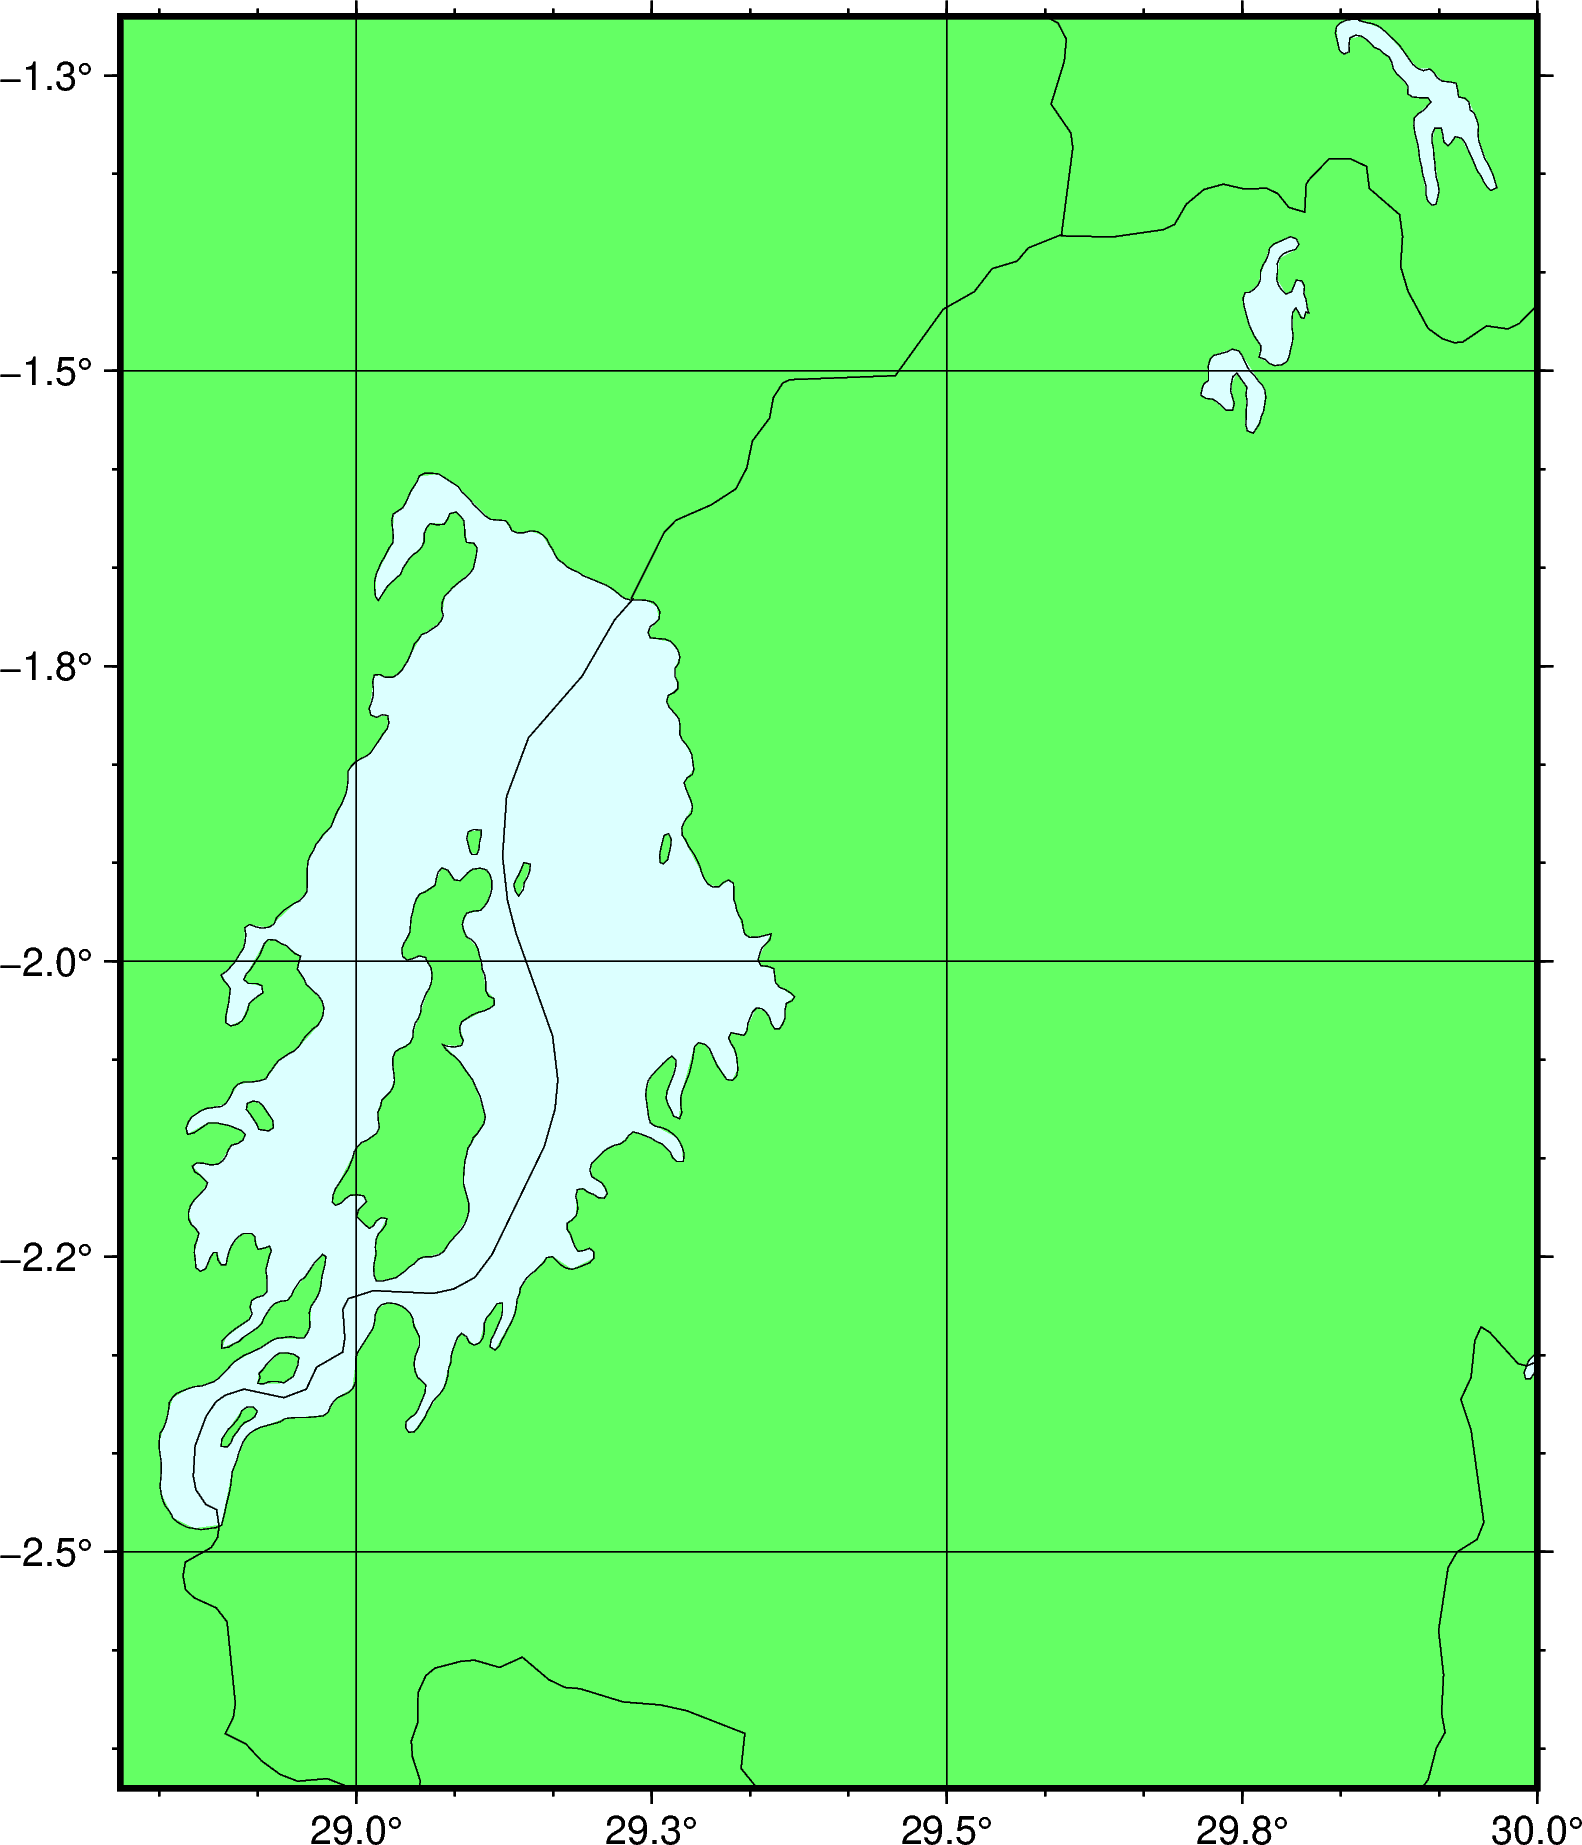

In [1]:
# Rwanda-Kivu Rift region
# we will start by making a prelim plot to assure that this is the region we want

import pygmt
xmin=28.8; xmax=30; ymin=-2.7;ymax=-1.2
region=[xmin,xmax,ymin,ymax]

fig1=pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain", # no alternating B&W 
             FORMAT_GEO_MAP='ddd.x') # decimal degrees
fig1.coast(region=region,  # xmin,xmax,ymin,ymax
           frame=['p','WSen','xa0.1g.5', 'ya.1g.5'], 
           land='100/255/100', water='220/255/255',
           resolution='h', 
           borders=1
          )
# add lakes
fig1.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
           resolution='f'
          )

fig1.show()

### Download high-resolution DEM
**S**huttle **R**adar **T**opography **M**ission high resolution data are available through the `elevation` package.  We will request only what we need

In [2]:
import elevation
import os

# gets proper path declaration independent of OS
# this will default to the global 90m resolution --way big enough for us

libdir=os.path.join(os.getcwd(),'mapdata')
if not os.path.exists(libdir):    # mkdir if doesn't exist
    os.mkdir(libdir)

   
DEM=os.path.join(libdir,'Rwanda_DEM.tif') 

# should define product='SRTM3' = 90m data (3arcsec), otherwise will default to 1arcsec
elevation.clip(bounds=(xmin,ymin,xmax,ymax),output=DEM,product='SRTM3')
elevation.clean()  # allows us to rerun get command

print(pygmt.grdinfo(DEM)) # shows useful information about the grid file

make: Nothing to be done for `download'.
make: Nothing to be done for `all'.
cp SRTM3.vrt SRTM3.5ad28b1837c74a0eac889fab1264e8c1.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 28.8 -1.2 30.0 -2.7 SRTM3.5ad28b1837c74a0eac889fab1264e8c1.vrt /Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata/Rwanda_DEM.tif
rm -f SRTM3.5ad28b1837c74a0eac889fab1264e8c1.vrt
find cache -size 0 -name "*.tif" -delete
rm -f SRTM1.*.vrt
rm -f -r spool/*
/Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata/Rwanda_DEM.tif: Title: Grid imported via GDAL
/Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata/Rwanda_DEM.tif: Command: 
/Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata/Rwanda_DEM.tif: Remark: 
/Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata/Rwanda_DEM.tif: Pixel node registration used [Geographic grid]
/Users/an77/Documents/Classes/PracticalCoding/pyGMT-Tutorial/mapdata

## Create initial DEM plot 
to assure things are working.  

Default GMT CPT choices are [shown here](https://docs.generic-mapping-tools.org/latest/cookbook/cpts.html#of-colors-and-color-legends)

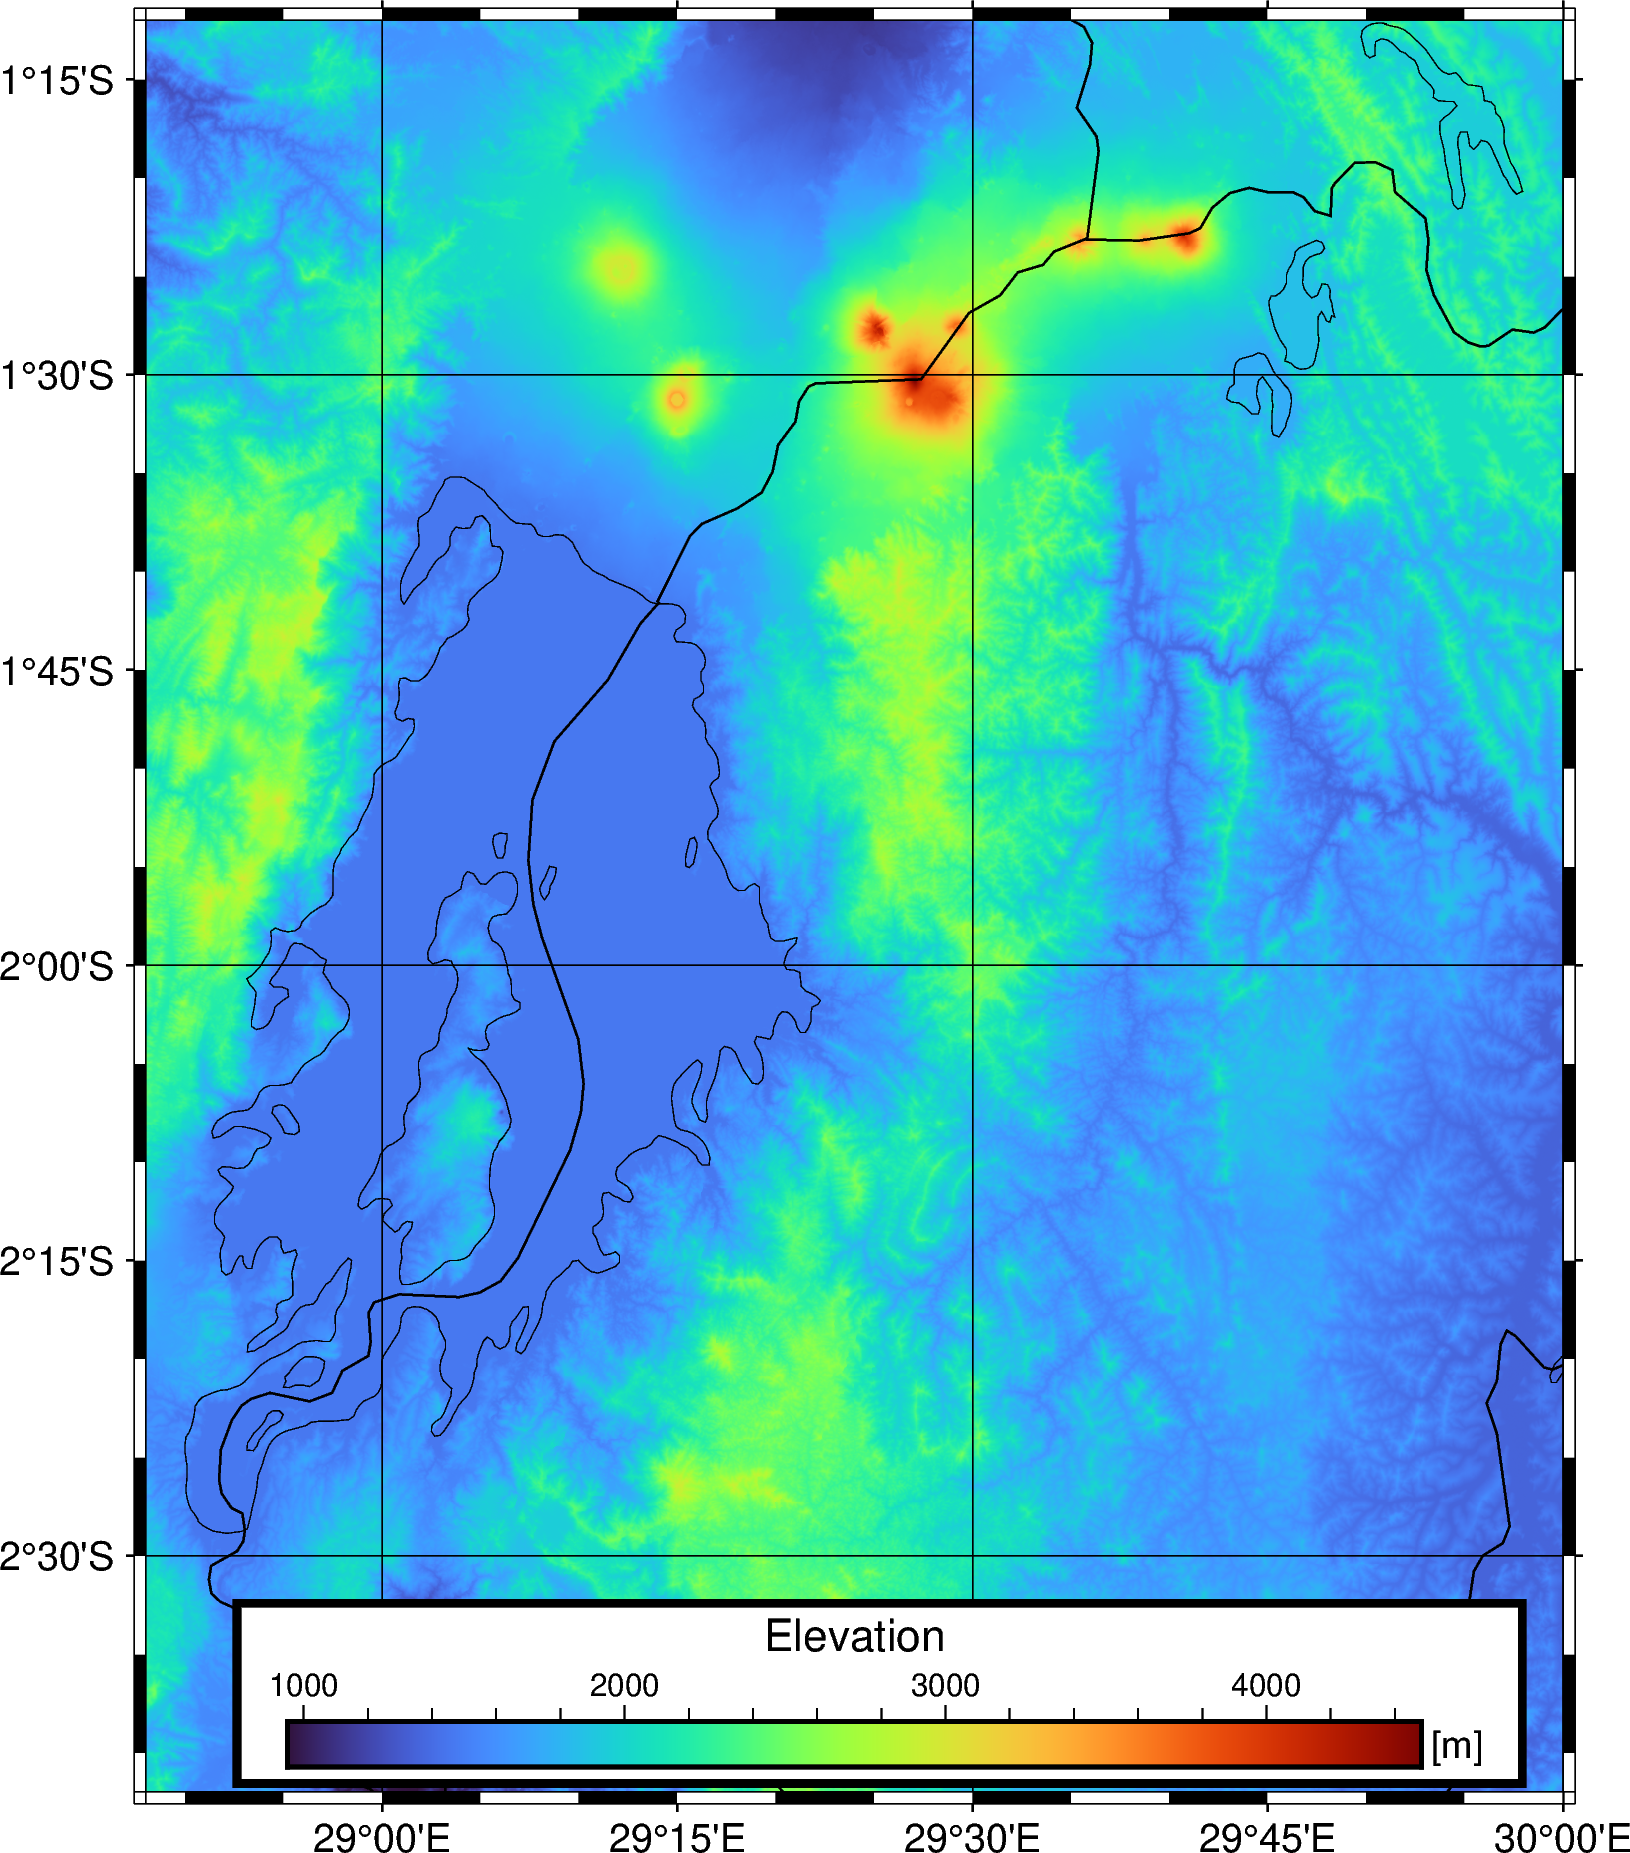

In [3]:
fig2=pygmt.Figure()

fig2.grdimage(DEM,cmap=True) # Use globe version (all high elev.)
fig2.coast(region=[xmin,xmax,ymin,ymax],  # xmin,xmax,ymin,ymax
    frame=['p','WSen','xa0.1g.5', 'ya.1g.5'], 
    resolution='h', 
    borders='1/0.5p'
    )
fig2.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
    resolution='f'
    )
fig2.colorbar(
    position="jBC", 
    box="+gwhite+p2,black", # white fill
    frame=['x+lElevation','y+l[m]']
)
        
fig2.show()

## another attempt
will add default shading and use a more familiar color pallete

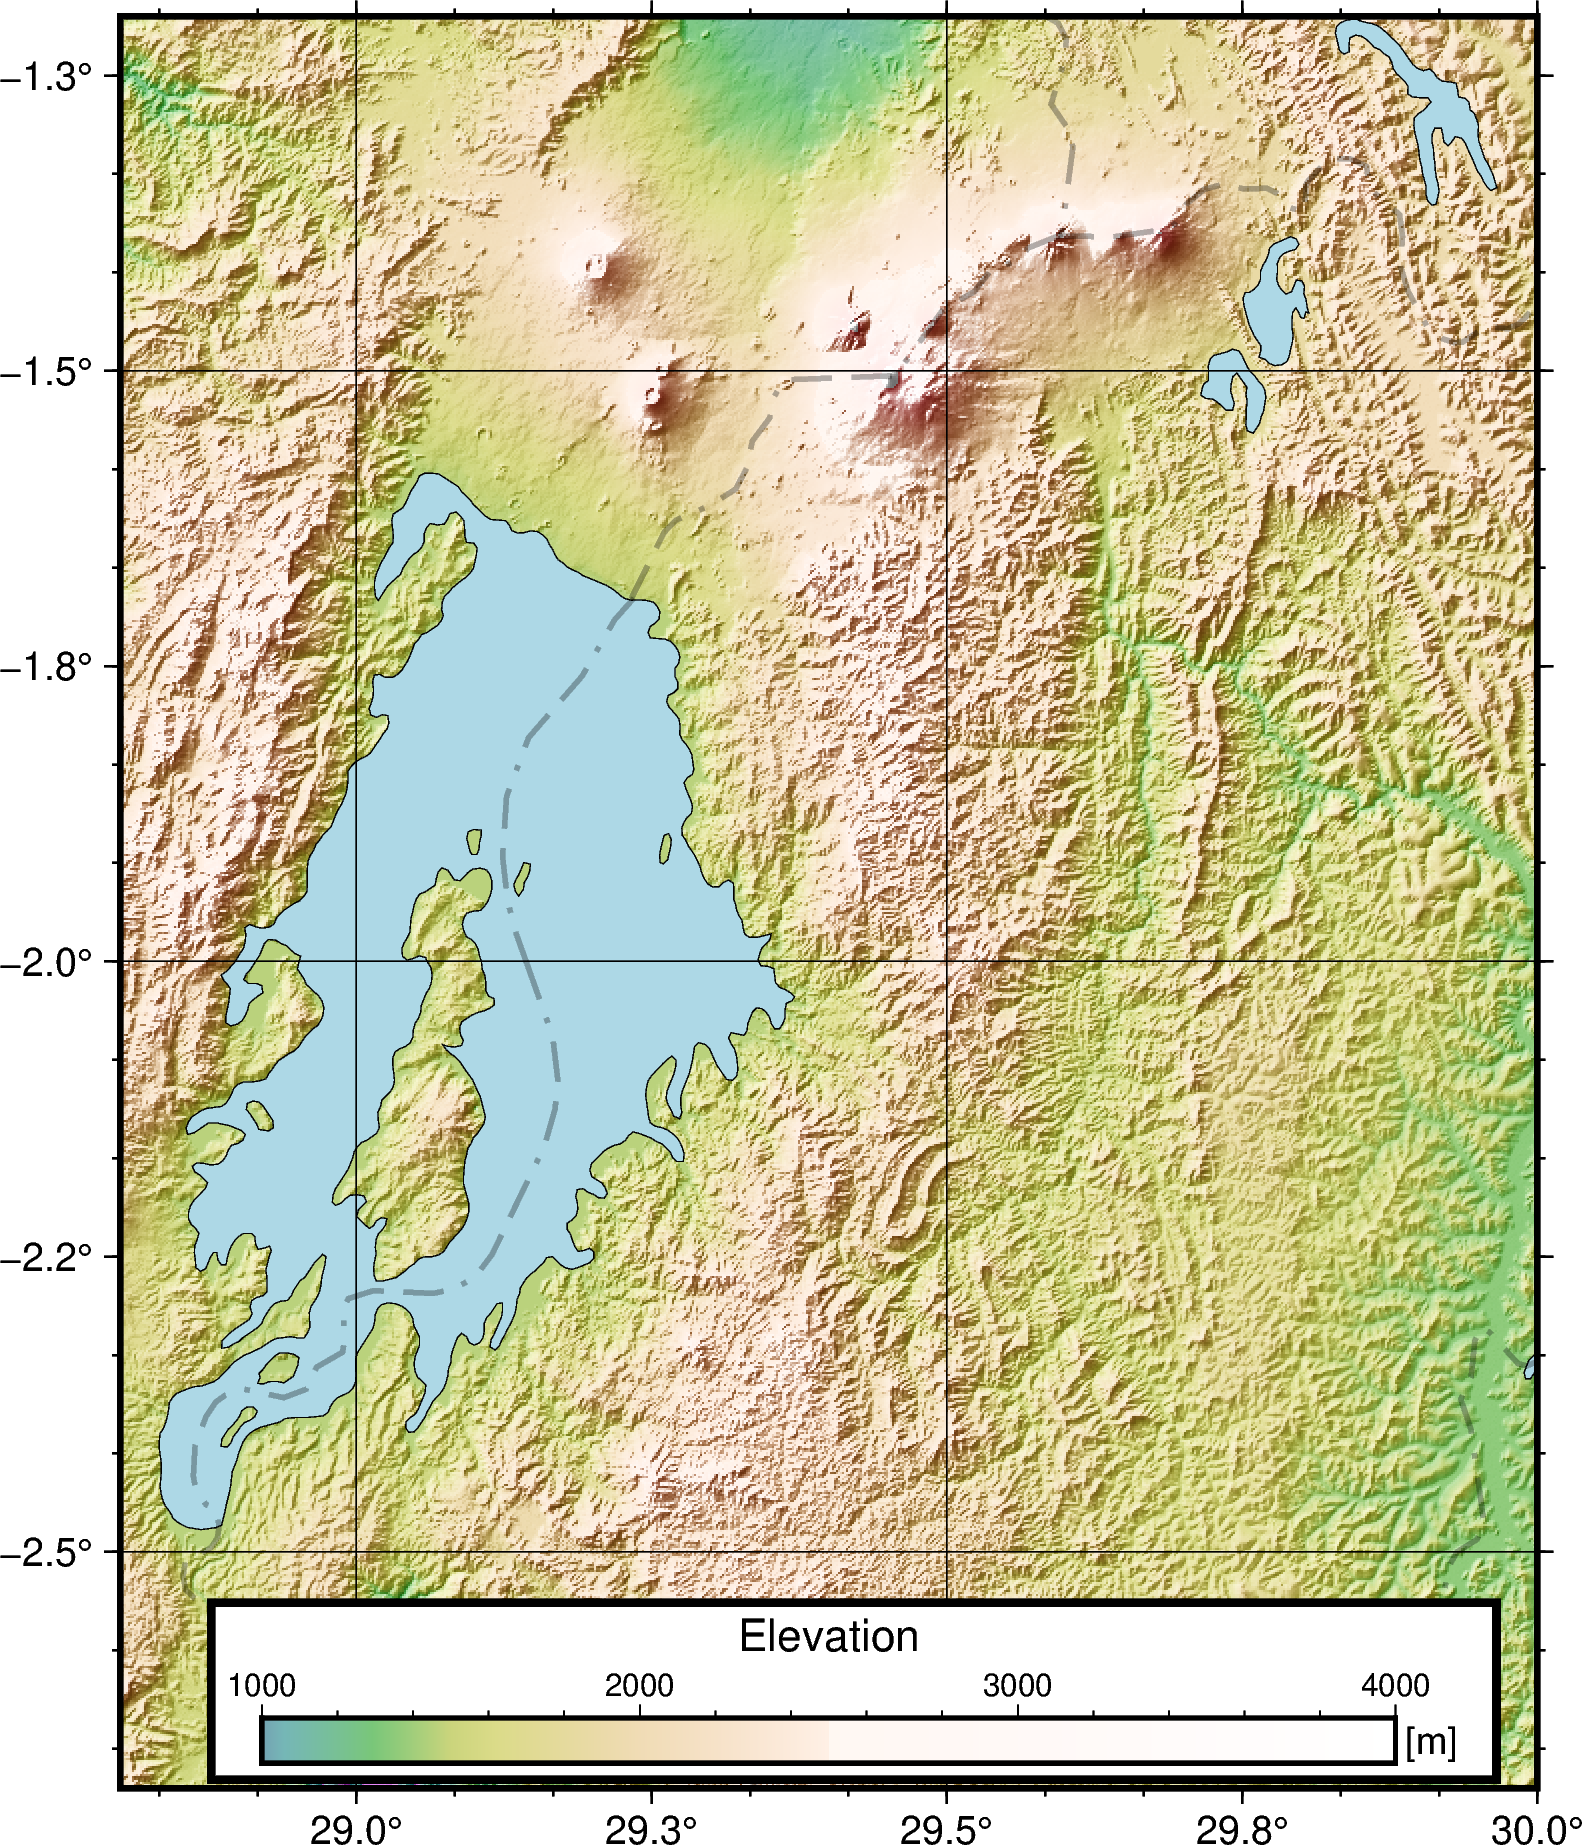

In [9]:
fig3=pygmt.Figure()

pygmt.config(MAP_FRAME_TYPE="plain", # no alternating B&W frame
             FORMAT_GEO_MAP='ddd.x') # decimal degrees

pygmt.makecpt(series=[1000,4000,500],  #create a topo cpt just for this range (500-4500m)
              continuous=True,
              cmap='topo')

fig3.grdimage(DEM,cmap=True,shading=True,dpi=150) # Use globe version (all high elev.)
fig3.coast(
    shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
    frame=['p','WSen','xa0.1g.5', 'ya.1g.5'], 
    lakes='lightblue',
    #transparency=50,
    resolution='f',
    )

# remap the national borders as dashed lines
fig3.coast(region=[xmin,xmax,ymin,ymax],  # xmin,xmax,ymin,ymax
    resolution='h', 
    borders='1/1.2p,-.-',
    transparency=70,
    )

fig3.colorbar(
    position="jBC", 
    box="+gwhite+p2,black", # white fill
    frame=['x+lElevation','y+l[m]']
    )

fig3.show()

In [10]:
fig3.savefig('Rwanda_topo.png', anti_alias=True,dpi=150,show=True)

## take a closer look at the topography data


In [6]:
# Use a built-in tool to breakdown the gradient information in the 
#  topography data into the azimuth and gradient magnitude 

# we will save the data into files within the 'mapdata' director
azimgrd=os.path.join(libdir,'Rwanda_DEM_azim.grd')  
slopegrd=os.path.join(libdir,'Rwanda_DEM_slope.grd') 

pygmt.grdgradient(DEM,
                 direction='a', # read down-slope rather than up-slope direction
                 outgrid=azimgrd,
                 slope_file=slopegrd
                 )
#pygmt.grdinfo(slopegrd)

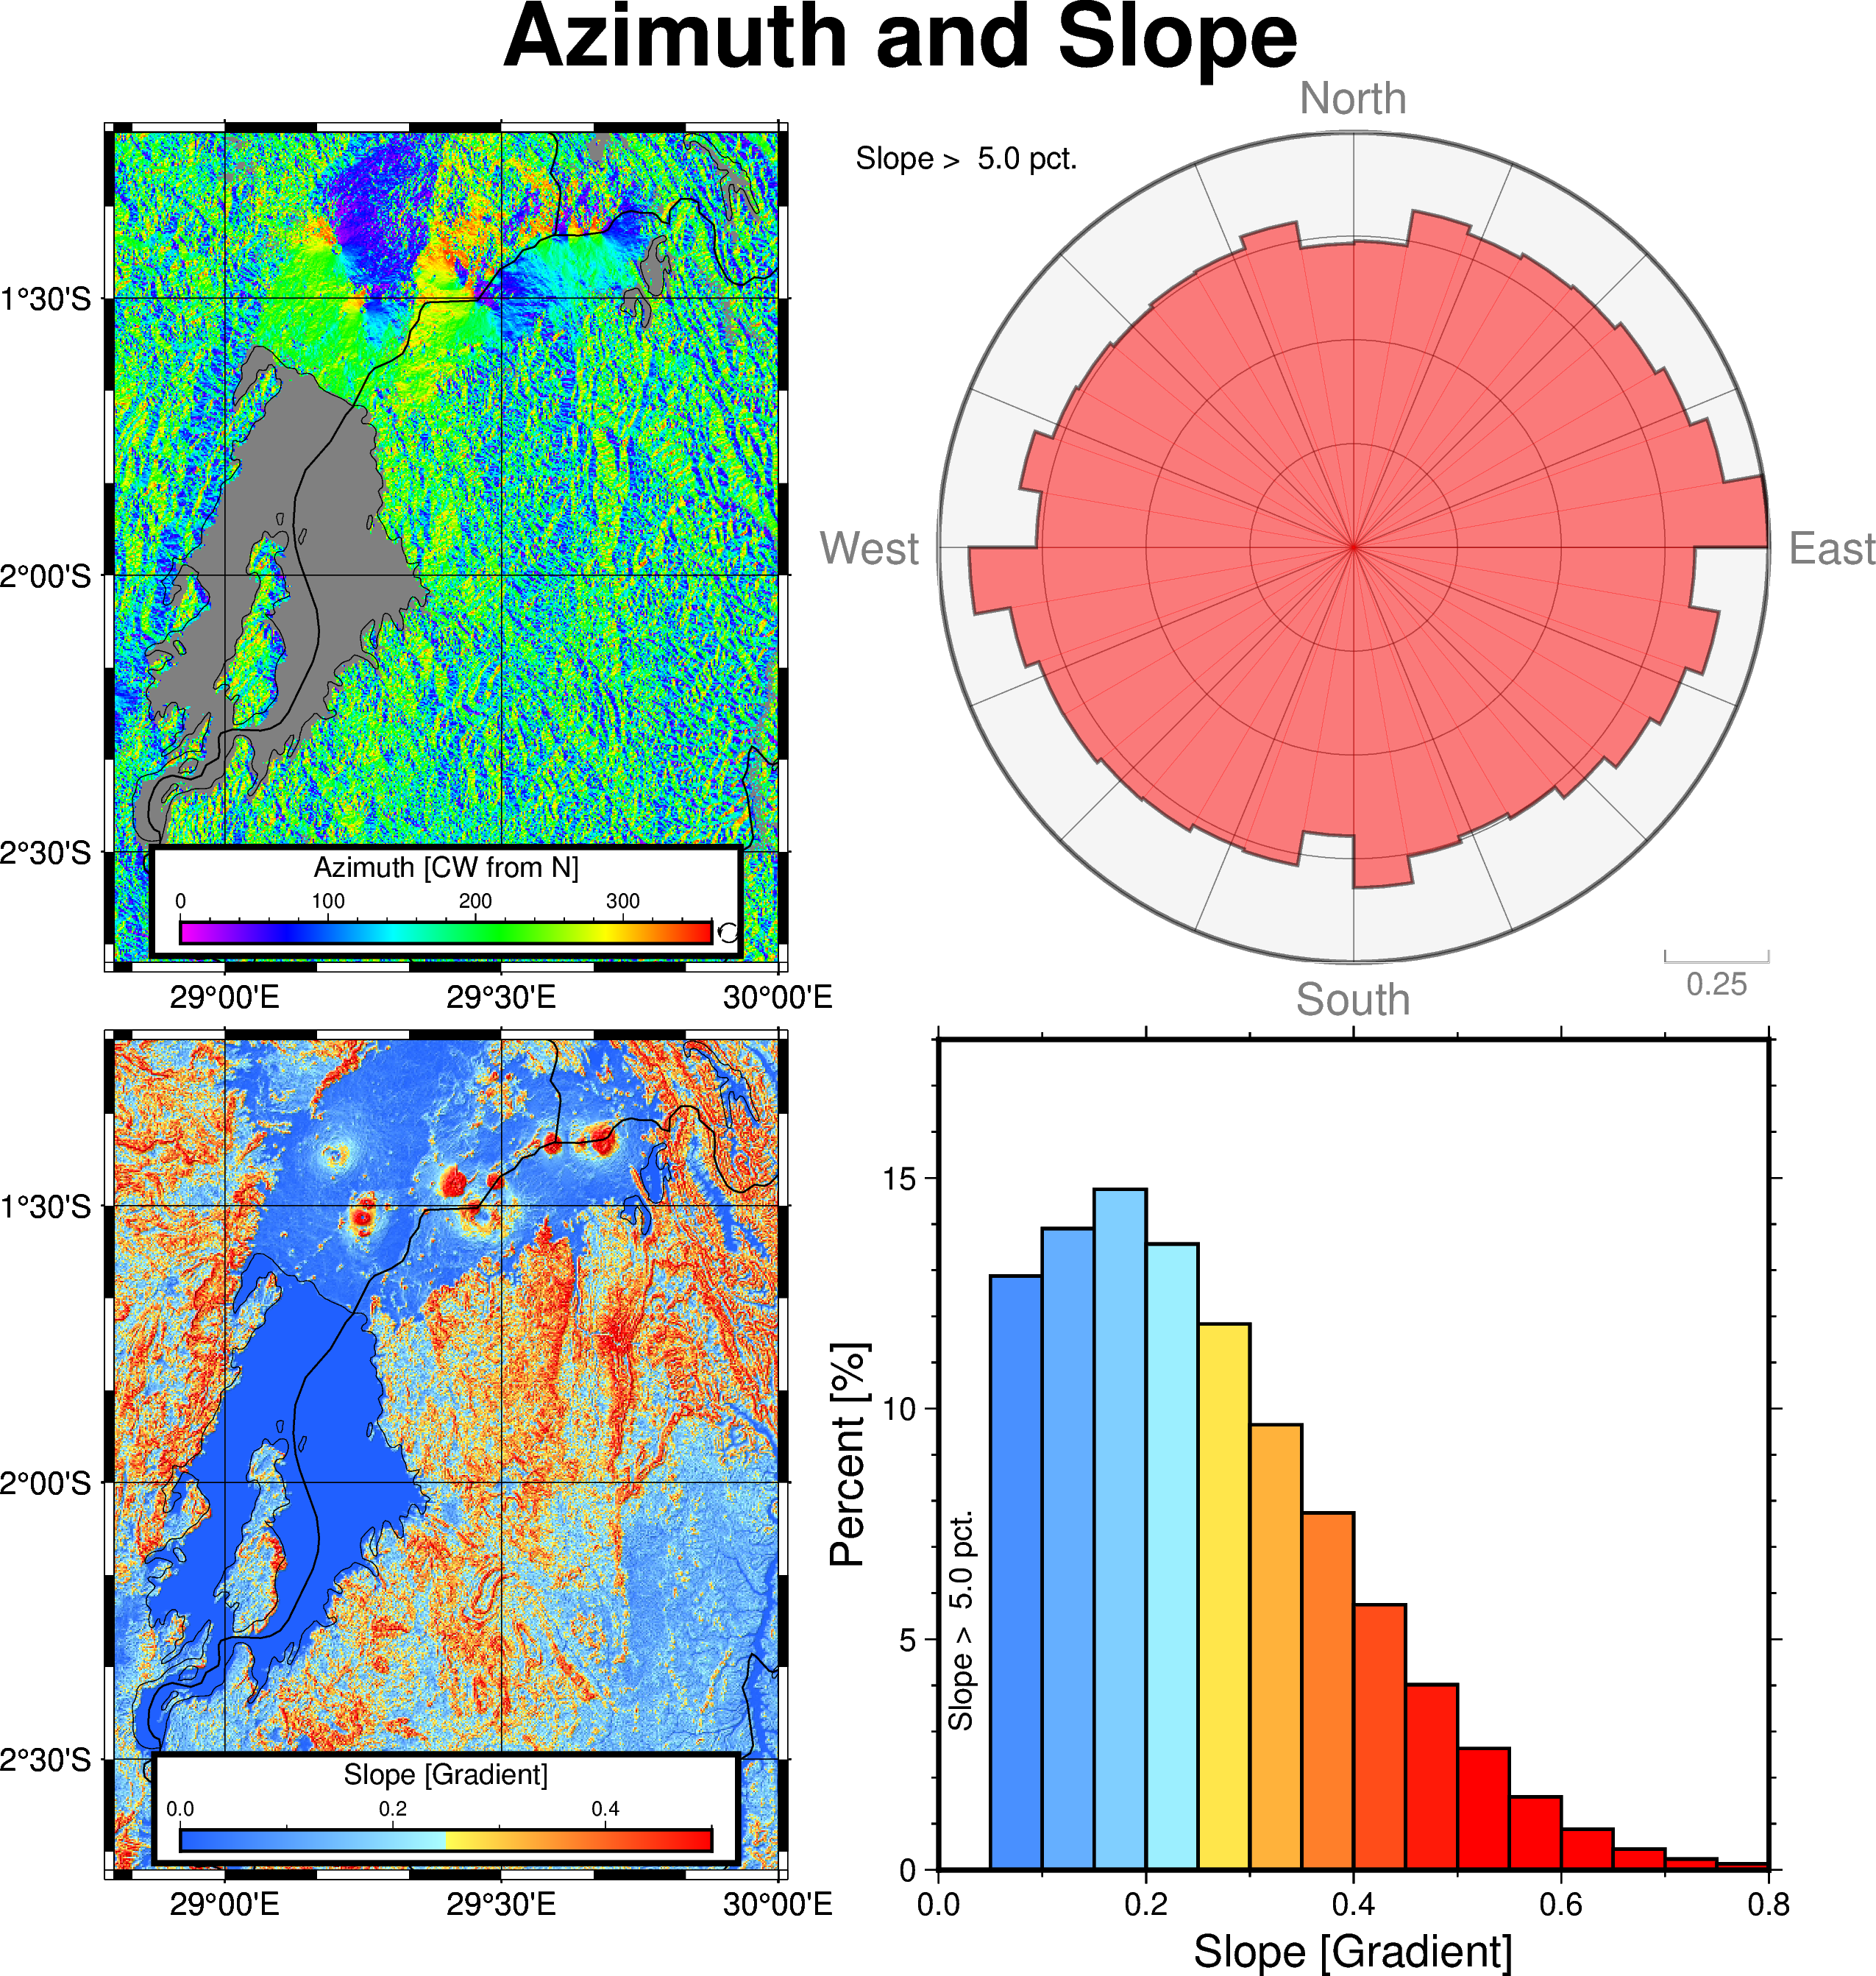

In [11]:
# We will make a 4-panel composite plot (after all, many journals charge per-figure, not per-panel ;) )
import numpy as np
import pandas as pd

fig4=pygmt.Figure()

minGrad=0.05 #(0.5%)
# Define panels
with fig4.subplot(nrows=2,ncols=2,figsize=('20c','20c'),
              title='Azimuth and Slope'):
    # top-left plot: Azimuth map
    with fig4.set_panel(panel=0):
        pygmt.makecpt(series=[0,360,45],  
              continuous=True,
              cyclic=True,
              cmap='rainbow')
        fig4.grdimage(azimgrd,cmap=True,dpi=150)
        fig4.coast(region=[xmin,xmax,ymin,ymax],  
            frame=['p','WSen','xa0.1g.5', 'ya.1g.5'], 
            resolution='h', 
            borders='1/0.5p'
            )
        fig4.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
            resolution='f'
            )
        fig4.colorbar(
            position="jBC", 
            box="+gwhite+p2,black", # white fill
            frame=['x+lAzimuth [CW from N]']
        )
    # top-right plot: rosette histogram (likely an easier way than what I did)
    with fig4.set_panel(panel=1):
        # a bunch of math to redistribute and bin slope values
        # save as a pandas array
        pdAZ = pygmt.grd2xyz(grid=azimgrd, output_type="pandas")['z']
        pdGrad =pygmt.grd2xyz(grid=slopegrd, output_type="pandas")['z']
        binwidth=10  # width of bin in degrees
        nbins=int(360/binwidth) # how many bins will fit with above width?
        bins=list(np.array(list(range(nbins+1)))*binwidth) # define bin-ranges (bounds)
        labels=list(np.array(list(range(nbins)))*binwidth+binwidth/2) # define mid-point of bins
        azvals=pd.cut(x=pdAZ[pdGrad[pdGrad > minGrad].index], bins=bins, labels=labels).value_counts() # counts within each bin
        binnedaz=np.array([azvals.index,azvals/sum(azvals)]) # numpy array with normalized counts per bin
        
        fig4.rose(
            azimuth=binnedaz[0],
            length=binnedaz[1],
            region=[0,1,0,360],
            norm=True,
            fill='red',
            transparency=50,
            sector=binwidth,
            frame=['x0.25g0.25', 'y22.5g22.5','+g235'],
            pen="1p,black"
        )
        with pygmt.config(MAP_FRAME_PEN="0,white"):
            proj="X?"
            fig4.basemap(region=[0,1,0,1], projection=proj,frame='wesn')
            fig4.text(text="Slope > %4.1f pct." % (minGrad*100),x=-0.1,y=0.97, 
                      justify="LM", font="10p,Helvetica,black", no_clip=True, angle=0)
    
    # Bottom-left Grad. magnitude (slope)
    with fig4.set_panel(panel=2):
        pygmt.makecpt(series=[0,.5,.25],  #grad
              continuous=True,
              cmap='no_green')
        fig4.grdimage(slopegrd,cmap=True,shading=True, dpi=150) 
        fig4.coast(region=[xmin,xmax,ymin,ymax], 
            frame=['p','WSen','xa0.1g.5', 'ya.1g.5'], 
            resolution='h', 
            borders='1/0.5p'
            )
        fig4.coast(shorelines=['1/0.2p','2/0.2p','3/0.2p','4/0.05p'],
            resolution='f'
            )
        fig4.colorbar(
            position="jBC", 
            box="+gwhite+p2,black", 
            frame=['x+lSlope [Gradient]']
        )
    # Bottom-Right Histogram of slopes (very straight-forward)     
    with fig4.set_panel(panel=3):
        #grid_dist = pygmt.grd2xyz(grid=slopegrd, output_type="pandas")['z']
        pygmt.makecpt(series=[0,.5,.25],  #grad
              continuous=True,
              cmap='no_green')
        fig4.histogram(
            data=pdGrad[pdGrad[pdGrad > minGrad].index],
            projection="X?",
            region=[0,0.8,0,18], # bounding box
            series=[0,0.8,0.05], # range an bin size
            frame=["p",'WSen','xa0.1+lSlope [Gradient]', 'y5a10+lPercent [%]'],
            cmap=True,
            histtype=1, # percent of total
            pen="1p,black"
        )
        fig4.text(text="Slope > %4.1f pct." % (minGrad*100),x=0.02,y=3,  # position here is with respect to plot coordinates
                      justify="LM", font="10p,Helvetica,black", angle=90)
        
fig4.show()

In [12]:
fig4.savefig('Rwanda_Kivu_topo.png',dpi=150,anti_alias=True,show=True)